<a href="https://colab.research.google.com/github/ThePingPing/Torch_Model/blob/main/CuverTimeSerieModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction a Complexing data using RNN

In [ ]:
## import Libs

import torch
import torch.nn as nn
import numpy as np

from torch.optim import Adam, SGD

import sys

import matplotlib.pyplot as plt
import time

In [ ]:
## for the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
### Set parameters For the RNN model

""" Points for the time Series """
num_points = 500

input_size = 1 ## number of different features
hidden_size = 9
num_layers = 1
activation_func = 'tanh'
bias = True

message = False

## Set the hyper parmetere seqlength, batchsize
batchsize = 1
""" really carfully with this parameter Coz you have to take enought point to learn the patterne """
seqlength = 90

## for the Train func

numbers_epochs = 30
name_model = "Time Series Curve"

In [ ]:
def create_data(num_points, seqlength):

  t_time = torch.linspace(0, 30*np.pi, num_points)
  data = torch.sin(t_time + torch.cos(t_time)) ## the data choose is Sin(t + Cos(t))

  ## plot the Data from the complet and the first Seq

  fig, ax = plt.subplots(1,2,figsize=(15,4))
  ax[0].plot(data,'gs-',markerfacecolor='w')
  ax[0].set_title("The complet Data")


  ax[1].plot(data[:seqlength],'gs-',markerfacecolor='w')
  ax[1].set_title("The first seq")

  plt.show()

  return data


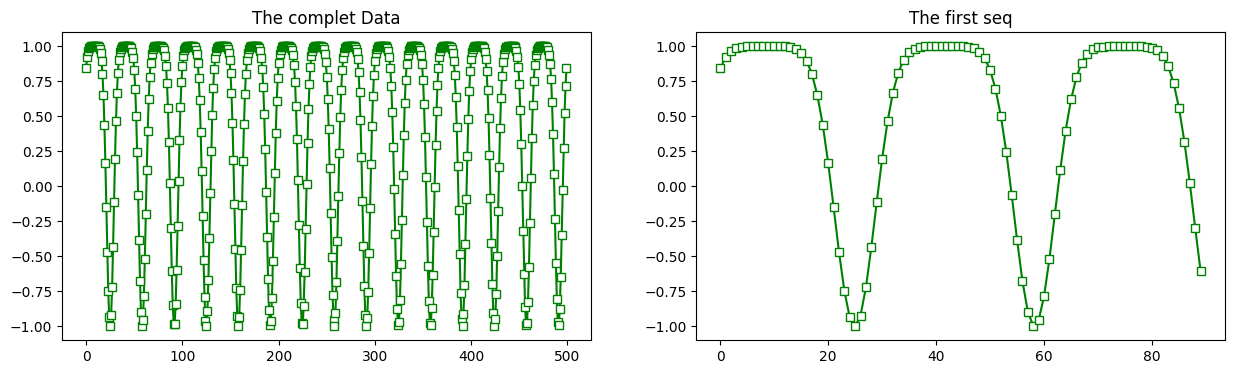

In [ ]:
data = create_data(num_points, seqlength)

In [ ]:
class RNNnet(nn.Module):

  def __init__(self, printtoggle, input_size, num_hidden, num_layers):
    super().__init__()

    """ for the Toggle """
    self.print = printtoggle

    """ define the variable """

    self.input_size = input_size
    self.num_hidden = num_hidden
    self.num_layers = num_layers

    ## The RNN

    self.rnn = nn.RNN(input_size, num_hidden, num_layers)

    ## the output layers --> linear

    self.linearOut = nn.Linear(num_hidden, 1)

  def forward(self, x):

    if self.print: print(f'Input:{list(x.shape)}')

    ## initialize hidden State for the first input

    hidden = torch.zeros(self.num_layers, batchsize, self.num_hidden)

    if self.print: print(f'Hidden:{list(hidden.shape)}')

    ## run through the Rnn Layer

    y, hidden = self.rnn(x, hidden)

    if self.print: print(f'Out From RNN:{list(y.shape)}')
    if self.print: print(f'Hidden From RNN:{list(hidden.shape)}')

    out = self.linearOut(y)
    if self.print: print(f'From linearOut:{list(out.shape)}')

    return out, hidden

In [ ]:
def initialize_model(message, input_size, hidden_size, num_layers):

  RnnModel = RNNnet(message,  input_size, hidden_size, num_layers)
  loss_function = nn.MSELoss() ## predict numerical value
  learning_rate = (10 ** -3)
  optimizer = SGD(RnnModel.parameters(), lr=learning_rate)

  print(RnnModel)
  print("")
  for p in RnnModel.named_parameters():
    print(f"{p[0]} has the size : {list(p[1].shape)}")

  return RnnModel, loss_function, optimizer

In [ ]:
RnnModel, loss_function, optimizer = initialize_model(message, input_size, hidden_size, num_layers)

RNNnet(
  (rnn): RNN(1, 9)
  (linearOut): Linear(in_features=9, out_features=1, bias=True)
)

rnn.weight_ih_l0 has the size : [9, 1]
rnn.weight_hh_l0 has the size : [9, 9]
rnn.bias_ih_l0 has the size : [9]
rnn.bias_hh_l0 has the size : [9]
linearOut.weight has the size : [1, 9]
linearOut.bias has the size : [1]


In [ ]:
def try_the_model(RnnModel, loss_function, seqlength, batchsize, input_size, data):
   ## Push fake Data into the Model

   data_seq = data[:seqlength].view(seqlength, 1, 1) ## REshape for the right size
   y = RnnModel(data_seq)

   """ Extract the value """
   final_val = y[0][-1]

   """ Push to the loss """

   loss = loss_function(final_val,  data[seqlength].view(1, 1))
   print(loss)

In [ ]:
try_the_model(RnnModel, loss_function, seqlength, batchsize, input_size, data)

tensor(0.9595, grad_fn=<MseLossBackward0>)


In [ ]:
def train_model(data, numbers_epochs, num_points, seqlength, message, name_model):


    ## Implement a new model , never see any data and Start a timer
    Model, loss_function, optimizer = initialize_model(message, input_size, hidden_size, num_layers)
    start_time = time.time()


    ## Push to GPU
    Model.to(device)

    # number of epochs

    ## initialize losses
    losses = torch.zeros(numbers_epochs)
    # accuracy = torch.zeros(numbers_epochs)

    ## loop over epochs
    for epochi in range(numbers_epochs):

        # loop over the data segmentation
        # Model.train()
        seg_loss = []
        seg_acc = []
        for seq in range(num_points - seqlength):


          ## Extract X, y with the lenght of the sequence and reshape it
          X = data[seq : seq+seqlength].view(seqlength, 1, 1)
          y = data[seq+seqlength].view(1, 1)


          # push data to the GPU

          X = X.to(device)
          y = y.to(device)

          # forward pass and loss
          yHat, hidden = Model(X)
          final_val = yHat[-1]
          loss = loss_function(final_val, y) ## compare the final value of the output

          # backprop
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # loss from this segment
          seg_loss.append(loss.item())

          # get the sigh from accuracy
          # true_sign = np.sign(torch.squeeze(y).numpy())
          # pred_sign = np.sign(torch.squeeze(final_val).detach().numpy())
          # seq_accuracy = 100 * (true_sign == pred_sign )##the Accuracy rate
          # seg_acc.append(seq_accuracy)
        # end of Seq loop...

        # and get average losses across the segmentations
        losses[epochi] = np.mean(seg_loss)
        msg = f" im Done the epoch {epochi + 1} / {numbers_epochs} "
        sys.stdout.write("\r" + msg)
        # accuracy[epochi] = np.mean(seg_acc)

    # end epochs
    ModelTrained = Model
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("The time computing for the Model training / retrainig is --> ", elapsed_time, " for the Model : ", name_model)

    # function output
    return ModelTrained, losses, name_model

In [ ]:
ModelTrained, losses, name_model = train_model(data, numbers_epochs, num_points, seqlength, message, name_model)

RNNnet(
  (rnn): RNN(1, 9)
  (linearOut): Linear(in_features=9, out_features=1, bias=True)
)

rnn.weight_ih_l0 has the size : [9, 1]
rnn.weight_hh_l0 has the size : [9, 9]
rnn.bias_ih_l0 has the size : [9]
rnn.bias_hh_l0 has the size : [9]
linearOut.weight has the size : [1, 9]
linearOut.bias has the size : [1]
 im Done the epoch 30 / 30 The time computing for the Model training / retrainig is -->  111.17431616783142  for the Model :  Time Series Curve


In [ ]:
def plot_train_result(loss, name):

  plt.figsize=(16,5)
  plt.plot(losses,'s-')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(f'Model loss for {name}')

  plt.show()

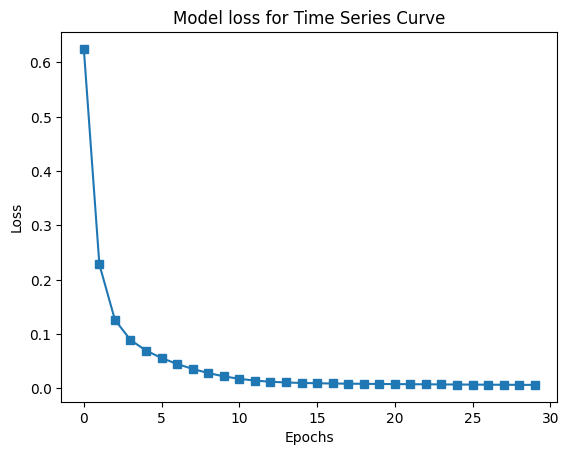

In [ ]:
plot_train_result(losses, name_model)

In [ ]:
def test_network(ModelTrained, data, num_points, hidden_size, seqlength):

  h = np.zeros((num_points, hidden_size))
  yHat = np.zeros(num_points)

  h_None = None

  for seq in range(num_points - seqlength):

    X = data[seq : seq + seqlength].view(seqlength, 1, 1)

    yy , hh = ModelTrained(X)
    yHat[seq + seqlength] = yy[-1]
    h[seq + seqlength, :] = hh.detach()

  ## plot the result

  fig, ax = plt.subplots(1, 3, figsize=(16, 4))
  ax[0].plot(data, "bs-", label = "Original Data", markersize = 3)
  ax[0].plot(yHat, "ro-", label = "Prediction", markersize = 3)
  ax[0].set_ylim([-1.1, 1.1])
  ax[0].legend()


  ax[1].plot(data-yHat,'k^')
  ax[1].set_ylim([-1.1,1.1])
  ax[1].set_title('Errors')

  ax[2].plot(data[seqlength:],yHat[seqlength:],'mo',markersize=3)
  ax[2].set_xlabel('Original Data')
  ax[2].set_ylabel('Prediction')
  r = np.corrcoef(data[seqlength:],yHat[seqlength:])
  ax[2].set_title(f"r={r[0,1]:.2f} (NO Simpson's paradox!)")

  plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
  plt.tight_layout()
  plt.show()



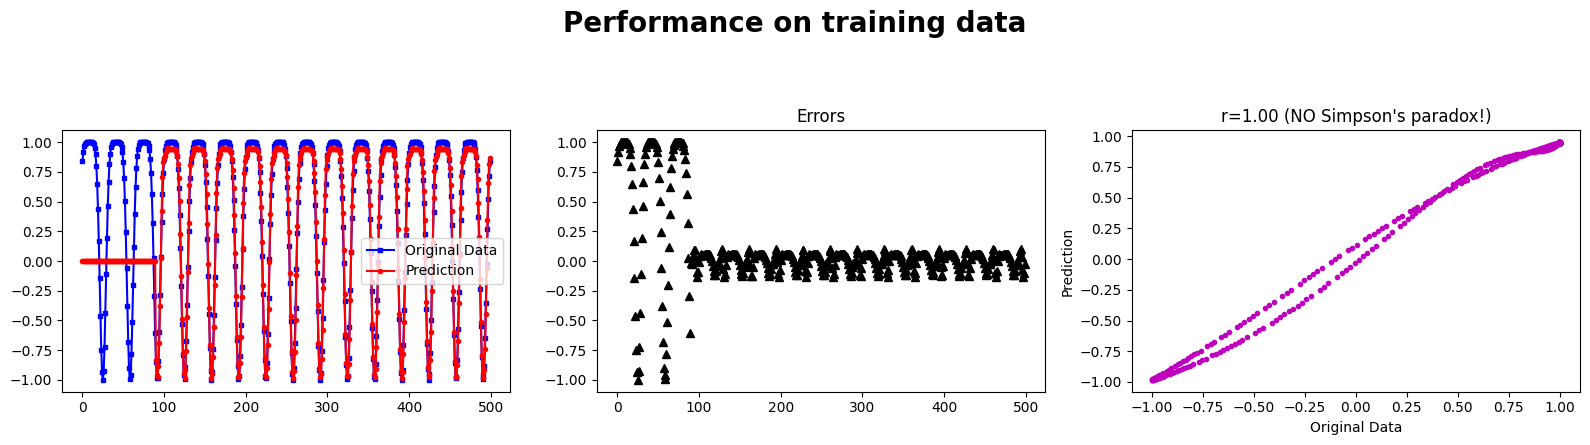

In [ ]:
test_network(ModelTrained, data, num_points, hidden_size, seqlength)

In [ ]:
def predicte_new_data(ModelTrained, data, num_points, hidden_size, seqlength):

  new_t_time = torch.linspace(0, 10*np.pi, num_points) ## change the frequence
  new_data = torch.sin(new_t_time + torch.cos(new_t_time))

  yHat = np.zeros(num_points)
  h = None

  for seq in range(num_points - seqlength):

    X = new_data[seq : seq + seqlength].view(seqlength, 1, 1)

    yy , h = ModelTrained(X)
    yHat[seq + seqlength] = yy[-1]

  # plotting
  fig,ax = plt.subplots(1,3,figsize=(16,4))
  ax[0].plot(new_data,'bs-',label='Original data',markersize=3)
  ax[0].plot(yHat,'ro-',label='Predicted',markersize=3)
  ax[0].set_ylim([-1.1,1.1])
  ax[0].legend()

  ax[1].plot(new_data-yHat,'k^',markersize=3)
  ax[1].set_ylim([-1.1,1.1])
  ax[1].set_title('Errors')

  ax[2].plot(new_data[seqlength:],yHat[seqlength:],'mo',markersize=3)
  ax[2].set_xlabel('Original data')
  ax[2].set_ylabel('Predicted data')
  r = np.corrcoef(new_data[seqlength:],yHat[seqlength:])
  ax[2].set_title(f"r={r[0,1]:.2f}")

  plt.suptitle('Performance on unseen test data',fontweight='bold',fontsize=20,y=1.1)
  plt.show()


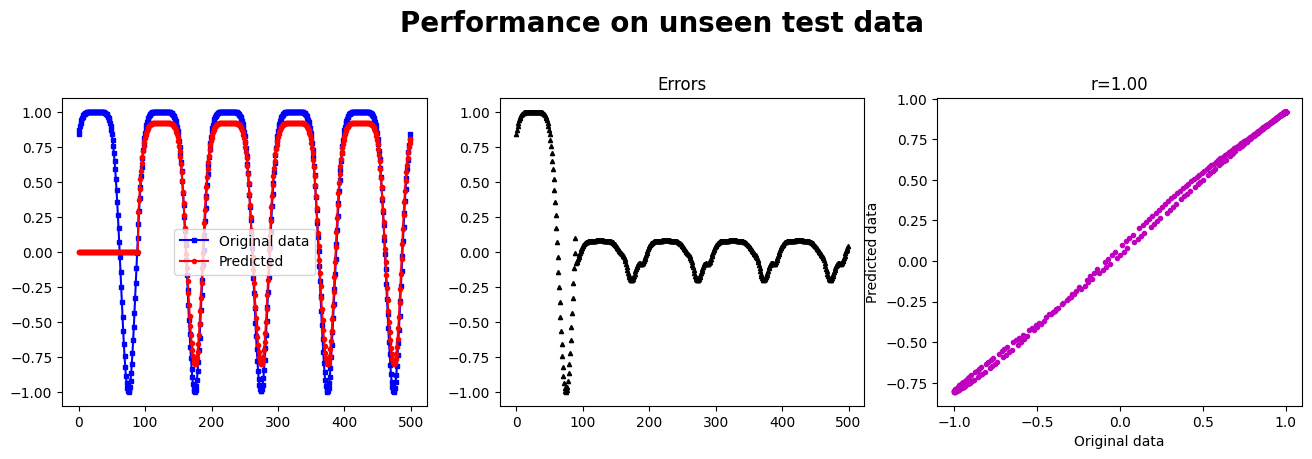

In [ ]:
predicte_new_data(ModelTrained, data, num_points, hidden_size, seqlength)

In [ ]:
def forcasting_extrapolation(ModelTrained, data, num_points, hidden_size, seqlength):
  # using original data

  # create a signal 2x as long
  yHat = torch.zeros(2*num_points) # torch, not np!
  yHat[:num_points] = data
  h = None

  for seq in range(2*num_points-seqlength):

    # grab a snippet of data
    X = yHat[seq:seq+seqlength].view(seqlength,1,1)

    # forward pass and loss
    yy,h = ModelTrained(X)
    yHat[seq+seqlength] = yy[-1]



  # convert back to np for plotting
  yHat = yHat.detach()

  # plotting
  fig = plt.figure(figsize=(12,4))
  plt.plot(data,'bs-',label='Original data',markersize=3)
  plt.plot(yHat,'ro-',label='Predicted',markersize=3)
  plt.ylim([-1.1,1.1])
  plt.legend()
  plt.title('Performance on extrapolated data')
  plt.show()

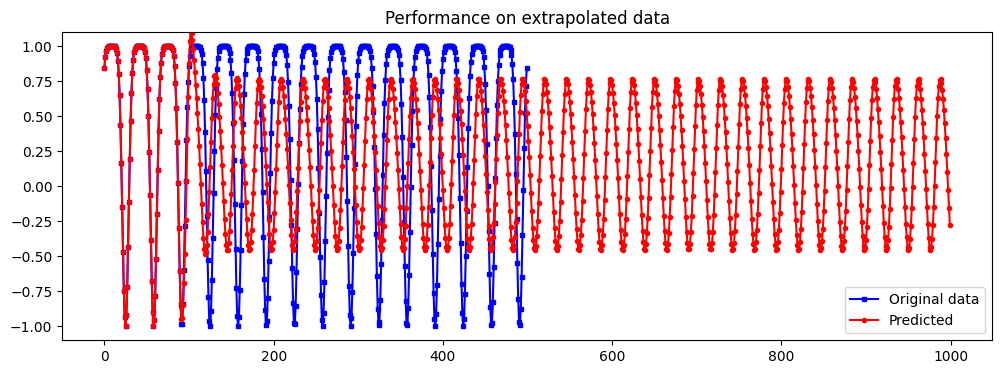

In [ ]:
forcasting_extrapolation(ModelTrained, data, num_points, hidden_size, seqlength)